# KAN-ODE

## KODE网络训练

### 安装依赖

In [33]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import torch.distributions as dists
import pandas as pd
from base_kan.ekan import EKAN 

### 定义网络
包含常规ODE和Neural ODE的SIR系统

In [35]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = []  # 用于记录neural_output

    def forward(self, t, y):
        S, I, R = y
        neural_output = self.neural_part(torch.tensor([S, I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  # 记录neural_output
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt])

### 初始化模型参数

In [36]:
gamma = 0.07
beta = 2 * gamma  #根据实际情况，参数beta是参数gamma的具体倍数
neural_ode_func = EKAN(layers_hidden=[2, 128, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

### 初始化参数

In [37]:
intial = 0.  ##时间区间的初始值
last= 60.    ##时间区间的终值
step = 60   ##时间步长
y0 = torch.tensor([0.99, 0.01, 0.0], requires_grad=True)  # 初始条件: S, I, R
t = torch.linspace(intial, last, step)  # 时间区间

### 无扰动部分

#### 生成真实数据

In [38]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I 
        dI_dt = beta * S * I  - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

#### 定义损失函数
##### 使用仅与I相关的损失函数

In [39]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 2] - true_y[:, 2]) ** 2)

#### 定义准确率计算函数
##### 使用仅与I相关的准确率函数

In [40]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 2] - true_y[:, 2])
    correct = (diff < threshold).float().mean()
    return correct.item()

#### 定义差分机计算公式

In [41]:
def forword_CF(x):
    # 将输入转换为tensor
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    # 检查输入长度是否至少为2
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    # 初始化输出数列，复制第一个元素
    result = x.clone().detach()
    
    # 计算后一项减前一项
    result[1:] = x[1:] - x[:-1]
    
    return result

#### 定义训练模型
##### 执行模型的训练

In [42]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(2000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

#### 进行训练

In [43]:
t, True_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.137433260679245, Accuracy: 3.33%
Iter 100, Loss: 0.002635558368638158, Accuracy: 13.33%
Iter 200, Loss: 0.002592372242361307, Accuracy: 13.33%
Iter 300, Loss: 0.0024778591468930244, Accuracy: 13.33%
Iter 400, Loss: 0.002337205922231078, Accuracy: 15.00%
Iter 500, Loss: 0.00217014504596591, Accuracy: 15.00%
Iter 600, Loss: 0.0019754490349441767, Accuracy: 16.67%
Iter 700, Loss: 0.0017513006459921598, Accuracy: 18.33%
Iter 800, Loss: 0.0014964864822104573, Accuracy: 18.33%
Iter 900, Loss: 0.001212889445014298, Accuracy: 20.00%
Iter 1000, Loss: 0.0009099913295358419, Accuracy: 23.33%
Iter 1100, Loss: 0.0006104279309511185, Accuracy: 26.67%
Iter 1200, Loss: 0.00035045205731876194, Accuracy: 36.67%
Iter 1300, Loss: 0.00016527180559933186, Accuracy: 48.33%
Iter 1400, Loss: 6.326000584522262e-05, Accuracy: 81.67%
Iter 1500, Loss: 2.080757803923916e-05, Accuracy: 95.00%
Iter 1600, Loss: 7.1909676080395e-06, Accuracy: 100.00%
Iter 1700, Loss: 3.6565602385962848e-06, Accuracy: 10

##### 将A进行差分

In [44]:
True_y[:,2] = forword_CF(True_y[:,2])
pred_y[:,2] = forword_CF(pred_y[:,2])

/tmp/ipykernel_2951828/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


#### 推理部分
#### 设置预测的时间

In [45]:
##将时间步长进行扩展
extend = 60
timeintial = intial
timeend = last + extend
timestep = step + extend
in_t = torch.linspace(timeintial, timeend, timestep)##预测接下来extend天的情况

#### 机理部分的推理

In [46]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I 
        dI_dt = beta * S * I  - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        in_true_y = odeint(sir, true_y0, in_t, rtol=1e-5, atol=1e-8)
    return in_t, in_true_y

in_t, in_true_y = get_data()

#### 神经网络部分的推理

In [47]:
with torch.no_grad():
    in_pred_y = odeint(model, y0, in_t, rtol=1e-5, atol=1e-8)

#### 进行差分

In [48]:
in_true_y[:,2] = forword_CF(in_true_y[:,2])
in_pred_y[:,2] = forword_CF(in_pred_y[:,2])

/tmp/ipykernel_2951828/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


#### 将最终数据保存至Excel

In [49]:
tdata = {
    'Time': t.numpy(),
    'True_S': True_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': True_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': True_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],

}

idata = {
    'Time': in_t.numpy(),
    'in_true_S': in_true_y.numpy()[:, 0],
    'in_Predicted_S': in_pred_y.detach().numpy()[:, 0],
    'in_true_I': in_true_y.numpy()[:, 1],
    'in_Predicted_I': in_pred_y.detach().numpy()[:, 1],
    'in_true_R': in_true_y.numpy()[:, 2],
    'in_Predicted_R': in_pred_y.detach().numpy()[:, 2],

}
dft = pd.DataFrame(tdata)
dfi = pd.DataFrame(idata)

##### 保存成Excel文件

In [50]:
dfi.to_excel('ZS-ti.xlsx', index=False)

### 加扰动部分
#### 生成真实数据

In [51]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I 
        dI_dt = beta * S * I  - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, y = get_data()

#### 加入噪声

##### 正态分布噪声

In [52]:
# # 正态分布的参数，mean（μ）是分布的均值，stddev（σ）是分布的标准差
# mean = 0.0  # 均值
# stddev = 0.01  # 标准差，可以根据需要调整这个值

# # 创建正态分布对象
# normal_dist = dists.Normal(mean, stddev)

# # 生成与原始数据相同形状的正态噪声
# normal_noise = normal_dist.sample(y.shape)

# # 将正态噪声添加到原始数据上
# true_y = y + normal_noise

##### 泊松分布的噪声

In [53]:
# # 泊松分布的参数，lambda（λ）是泊松分布的均值和方差
y = y * 10000
# 创建泊松分布对象
poisson_dist = dists.Poisson(y)
# # 生成与原始数据相同形状的泊松噪声
poisson_noise = poisson_dist.sample()
true_y = poisson_noise/10000
y = y/10000

#### 进行训练

In [54]:
t, Z_true_y, Z_pred_y, Z_neural_outputs = train()

Iter 0, Loss: 1.2600808076967951e-05, Accuracy: 100.00%
Iter 100, Loss: 0.002716199727728963, Accuracy: 13.33%
Iter 200, Loss: 0.006441502831876278, Accuracy: 28.33%
Iter 300, Loss: 0.0002858350344467908, Accuracy: 38.33%
Iter 400, Loss: 0.00011002402607118711, Accuracy: 56.67%
Iter 500, Loss: 4.513883686740883e-05, Accuracy: 91.67%
Iter 600, Loss: 2.1844703951501288e-05, Accuracy: 96.67%
Iter 700, Loss: 1.4318415196612477e-05, Accuracy: 98.33%
Iter 800, Loss: 1.2133141353842802e-05, Accuracy: 98.33%
Iter 900, Loss: 1.1563677617232315e-05, Accuracy: 100.00%
Iter 1000, Loss: 1.1424529475334566e-05, Accuracy: 100.00%
Iter 1100, Loss: 1.1384653589630034e-05, Accuracy: 100.00%
Iter 1200, Loss: 1.1361312317603733e-05, Accuracy: 100.00%
Iter 1300, Loss: 1.1340992386976723e-05, Accuracy: 100.00%
Iter 1400, Loss: 1.1319978511892259e-05, Accuracy: 100.00%
Iter 1500, Loss: 1.1296587217657361e-05, Accuracy: 100.00%
Iter 1600, Loss: 1.1273073141637724e-05, Accuracy: 100.00%
Iter 1700, Loss: 1.1248

##### 正态分布扰动

In [55]:
# # 正态分布的参数，mean（μ）是分布的均值，stddev（σ）是分布的标准差
# mean = 0.0  # 均值
# stddev = 0.0016  # 标准差，可以根据需要调整这个值

# # 创建正态分布对象
# normal_dist = dists.Normal(mean, stddev)

# # 生成与原始数据相同形状的正态噪声
# normal_noise = normal_dist.sample(True_y[:,3].shape)

# # 将正态噪声添加到原始数据上
# Z_true_y[:,3]  = True_y[:,3] + normal_noise

##### 泊松分布扰动

In [56]:
# # 泊松分布的参数，lambda（λ）是泊松分布的均值和方差
y = True_y[:,2] * 10000
# 创建泊松分布对象
poisson_dist = dists.Poisson(y)
# # 生成与原始数据相同形状的泊松噪声
poisson_noise = poisson_dist.sample()
Z_true_y[:,2] = poisson_noise/10000

##### 差分计算

In [57]:
Z_pred_y[:,2] = forword_CF(Z_pred_y[:,2])

/tmp/ipykernel_2951828/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


#### 设置预测的时间

In [58]:
##将时间步长进行扩展
extend = 60
timeintial = intial
timeend = last + extend
timestep = step + extend
in_t = torch.linspace(timeintial, timeend, timestep)##预测接下来extend天的情况

#### 神经网络部分的推理

In [59]:
with torch.no_grad():
    Z_in_pred_y = odeint(model, y0, in_t, rtol=1e-5, atol=1e-8)

##### 进行差分计算

In [60]:
Z_in_pred_y[:,2] = forword_CF(Z_in_pred_y[:,2])

/tmp/ipykernel_2951828/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


#### 将最终数据保存至Excel

In [61]:
tdata = {
    'Time': t.numpy(),
    'True_S': Z_true_y.numpy()[:, 0],
    'Predicted_S': Z_pred_y.detach().numpy()[:, 0],
    'True_I': Z_true_y.numpy()[:, 1],
    'Predicted_I': Z_pred_y.detach().numpy()[:, 1],
    'True_R': Z_true_y.numpy()[:, 2],
    'Predicted_R': Z_pred_y.detach().numpy()[:, 2],

}

idata = {   
    'Time': in_t.numpy(),
    'Z_in_pred_S': Z_in_pred_y.detach().numpy()[:, 0],
    'Z_in_pred_I': Z_in_pred_y.detach().numpy()[:, 1],
    'Z_in_pred_R': Z_in_pred_y.detach().numpy()[:, 2],
}
dft = pd.DataFrame(tdata)
dfi = pd.DataFrame(idata)


##### 保存成Excel文件

In [62]:
dfi.to_excel('ZS-zti.xlsx', index=False)
dft.to_excel('ZS-ti-z.xlsx', index=False)

### 绘制结果并将图片结果保存
#### 训练阶段可视化

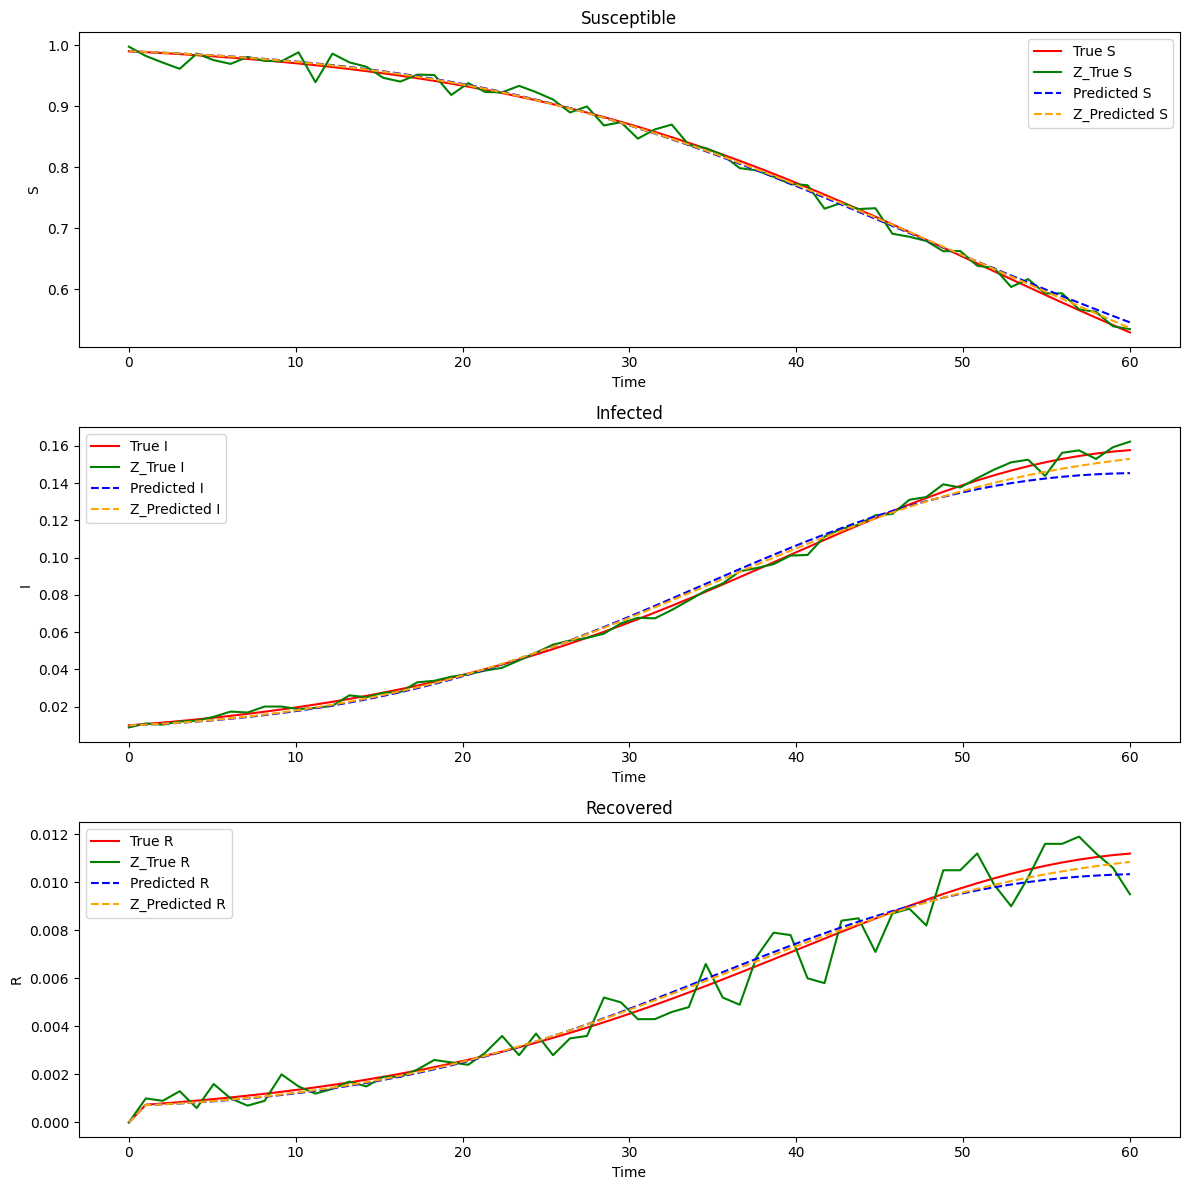

In [63]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), True_y.numpy()[:, 0], '-', label='True S', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 0], '-', label='Z_True S', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], '--', label='Predicted S', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 0], '--', label='Z_Predicted S', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), True_y.numpy()[:, 1], '-', label='True I', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 1], '-', label='Z_True I', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], '--', label='Predicted I', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 1], '--', label='Z_Predicted I', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), True_y.numpy()[:, 2], '-', label='True R', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 2], '-', label='Z_True R', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], '--', label='Predicted R', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 2], '--', label='Z_Predicted R', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')


plt.tight_layout()
plt.show()


#### 推理阶段可视化

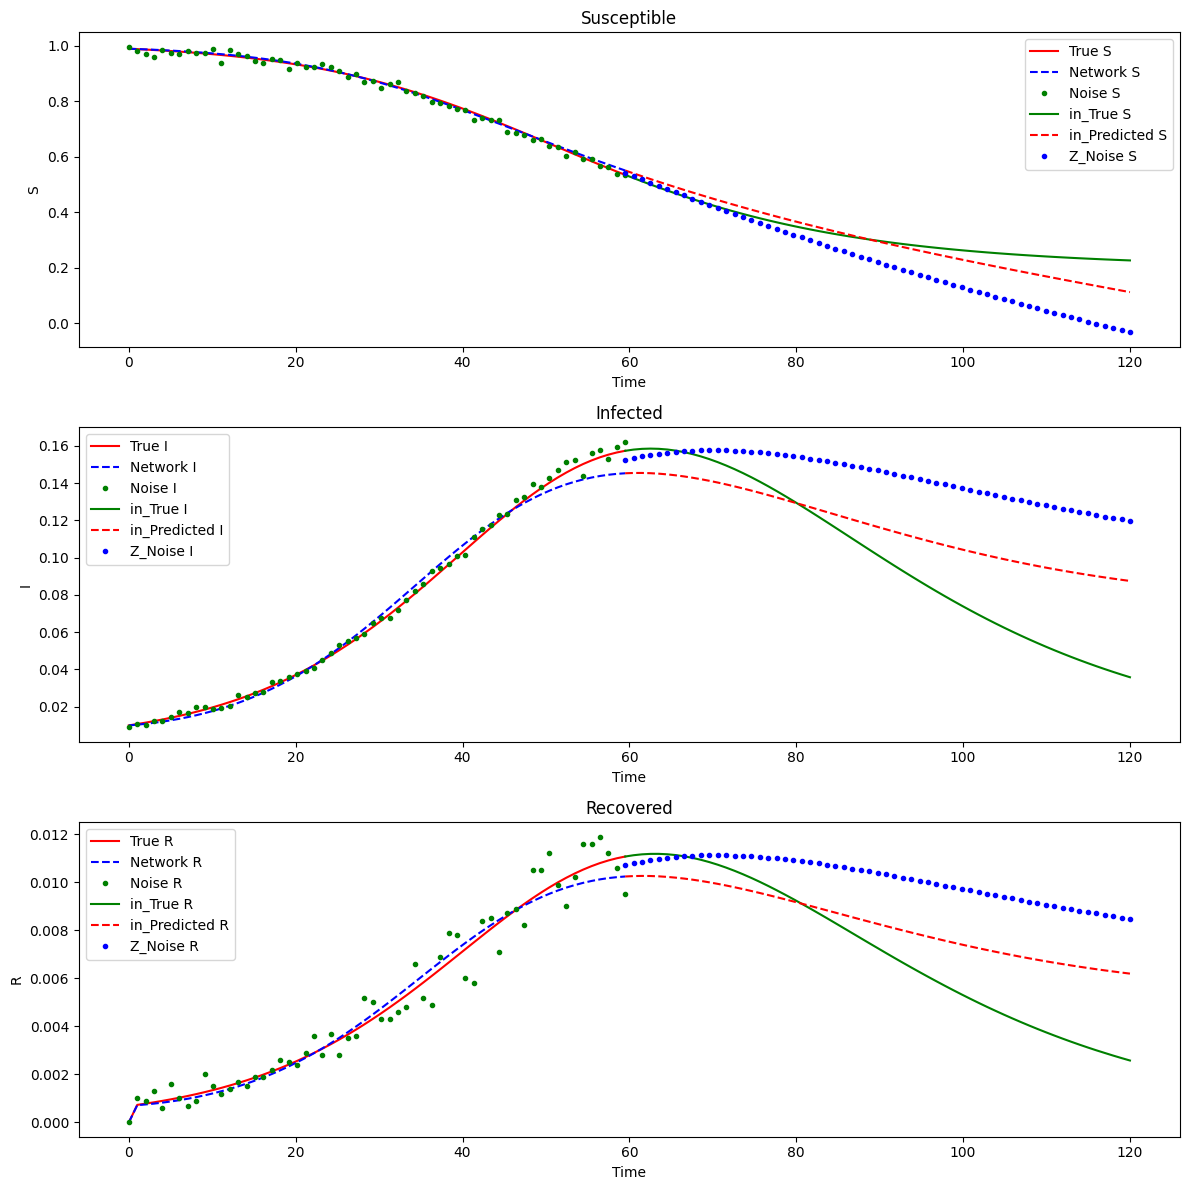

In [64]:
last = int(last)
timeend = int(timeend)
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 0], '-', label='True S', color='red')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 0], '--', label='Network S', color='blue')
plt.plot(in_t.numpy()[:last], Z_true_y.detach().numpy()[:last, 0], '.', label='Noise S', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 0], '-', label='in_True S', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 0], '--', label='in_Predicted S',color='red')
plt.plot(in_t.numpy()[last-1:timeend], Z_in_pred_y.detach().numpy()[last-1:timeend, 0], '.', label='Z_Noise S', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 1], '-', label='True I', color='red')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 1], '--', label='Network I', color='blue')
plt.plot(in_t.numpy()[:last], Z_true_y.detach().numpy()[:last, 1], '.', label='Noise I', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 1], '-', label='in_True I', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 1], '--', label='in_Predicted I',color='red')
plt.plot(in_t.numpy()[last-1:timeend], Z_in_pred_y.detach().numpy()[last-1:timeend, 1], '.', label='Z_Noise I', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 2], '-', label='True R', color='red')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 2], '--', label='Network R', color='blue')
plt.plot(in_t.numpy()[:last], Z_true_y.detach().numpy()[:last, 2], '.', label='Noise R', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 2], '-', label='in_True R', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 2], '--', label='in_Predicted R',color='red')
plt.plot(in_t.numpy()[last-1:timeend], Z_in_pred_y.detach().numpy()[last-1:timeend, 2], '.', label='Z_Noise R', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.show()